# Test script to export material textures from multi-view images

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image

In [2]:
# Load the parameters for uv unwrapping
output_path = "output"
device = "cuda"
uv_param = np.load(output_path + "_uv_coords.npz")
uv_coords = uv_param["uv_coords"] # [6, 768, 768, 2]
images_tensor = uv_param["images_tensor"]  # [6, 768, 768, 3]
masks = uv_param["masks"] # [6, 768, 768, 1]
v_tex = uv_param["v_tex"] # (2834041, 2)
t_tex_idx = uv_param["t_tex_idx"] # (3318336, 3)
print(f"check shape, uv_coords: {uv_coords.shape}, images_tensor: {images_tensor.shape}, masks: {masks.shape}, v_tex: {v_tex.shape}, t_tex_idx: {t_tex_idx.shape}")


check shape, uv_coords: (6, 768, 768, 2), images_tensor: (6, 768, 768, 3), masks: (6, 768, 768, 1), v_tex: (9927581, 2), t_tex_idx: (3318202, 3)


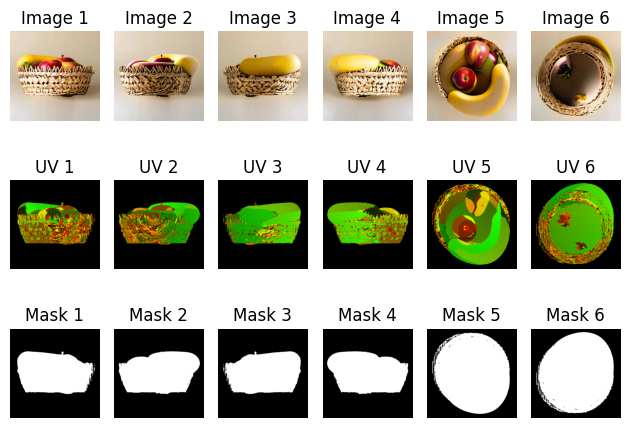

In [3]:
# Visualize the uv_coords
def visualize_uv_coords(uv_coords, images_tensor, masks):
    N = uv_coords.shape[0]  # Number of images

    # Create a figure with subplots
    fig, axs = plt.subplots(3, N)

    # Loop through each image and its corresponding uv coordinates
    for i in range(N):
        # Get the uv coordinates and mask for the current image
        uv = uv_coords[i]
        mask = masks[i]


        # Plot the original image
        axs[0, i].imshow(images_tensor[i])
        axs[0, i].set_title(f"Image {i + 1}")
        axs[0, i].axis("off")

        # Plot the uv coordinates
        uv_rgb = np.zeros((uv.shape[0], uv.shape[1], 3), dtype=np.uint8)
        uv_rgb[..., 0] = (uv[..., 0] * 255).astype(np.uint8)
        uv_rgb[..., 1] = (uv[..., 1] * 255).astype(np.uint8)
        axs[1, i].imshow(uv_rgb)
        axs[1, i].set_title(f"UV {i + 1}")
        axs[1, i].axis("off")

        # Plot the mask in grayscale
        axs[2, i].imshow(mask.squeeze(), cmap="gray")
        axs[2, i].set_title(f"Mask {i + 1}")
        axs[2, i].axis("off")

    plt.tight_layout()
    plt.savefig("uv_visualization.png", dpi=300)
    plt.show()
# Call the function to visualize the uv coordinates
visualize_uv_coords(uv_coords, images_tensor, masks)


In [4]:
# convert data from numpy to torch
uv_coords = torch.from_numpy(uv_coords).to(device)  
images_tensor = torch.from_numpy(images_tensor).to(device) 
masks = torch.from_numpy(masks).to(device)  

In [5]:
def bake_uv_texture_from_views(images_tensor, uv_coords, masks, texres=1024, inpaint=True):
    """
    Args:
        images_tensor: [N, H, W, 3], RGB images from N views
        uv_coords:     [N, H, W, 2], UV coords per view, in [0, 1]
        masks:         [N, H, W, 1], binary mask per view
        texres:        texture resolution (square)
        inpaint:       whether to apply OpenCV inpainting

    Returns:
        tex_img:       np.uint8 texture map of shape [texres, texres, 3]
    """
    device = images_tensor.device
    N, H, W, _ = images_tensor.shape

    # Flatten inputs
    uv = (uv_coords * (texres - 1)).long().view(-1, 2)
    rgb = images_tensor.view(-1, 3)
    mask_flat = masks.view(-1) > 0

    print(f"check flattened uv shape: {uv.shape}, rgb shape: {rgb.shape}, mask shape: {mask_flat.shape}")


    # Only keep valid UVs
    uv = uv[mask_flat]
    uv_coords = uv_coords.view(-1, 2)[mask_flat] # [193111, 2]]
    uv_rgb = torch.zeros((uv.shape[0], 3), dtype=torch.float32, device=device) # [193111, 3]

    uv_r = uv_coords[..., 0]
    uv_g = uv_coords[..., 1]
    uv_rgb[..., 0] = uv_r
    uv_rgb[..., 1] = uv_g
    uv_rgb[..., 2] = torch.zeros_like(uv_r, dtype=torch.float32) 

    
    rgb = rgb[mask_flat]
    print(f"check after mask uv shape: {uv.shape}, rgb shape: {rgb.shape}")

    # Flatten 2D UV to 1D index
    u, v = uv[:, 0], uv[:, 1]
    idx = u + (texres - 1 - v) * texres  # Y-down image space
    idx = idx.view(-1, 1).expand(-1, 3)

    # Initialize accumulators
    tex_acc = torch.zeros((texres * texres, 3), dtype=torch.float32, device=device)
    weight = torch.zeros((texres * texres, 1), dtype=torch.float32, device=device)

    tex_acc = tex_acc.scatter_add(0, idx, rgb)
    # tex_acc = tex_acc.scatter_add(0, idx, uv_rgb)
    weight = weight.scatter_add(0, idx[:, :1], torch.ones_like(idx[:, :1], dtype=torch.float32))

    tex_acc = tex_acc / (weight + 1e-6)
    tex_img = tex_acc.view(texres, texres, 3).clamp(0, 1)

    # Convert to CPU image
    tex_img_np = (tex_img.cpu().numpy() * 255).astype(np.uint8)

    if inpaint:
        inpaint_mask = (weight.view(texres, texres).cpu().numpy() == 0).astype(np.uint8)
        tex_img_np = cv2.inpaint(tex_img_np, inpaint_mask, 3, cv2.INPAINT_TELEA)

    return tex_img_np

check flattened uv shape: torch.Size([589824, 2]), rgb shape: torch.Size([589824, 3]), mask shape: torch.Size([589824])
check after mask uv shape: torch.Size([193111, 2]), rgb shape: torch.Size([193111, 3])
check tex_img range 0 - 254


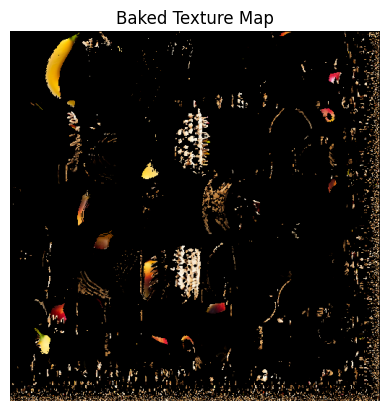

In [ ]:
num_views = 6
 # Project a single view for debugging
tex_img = bake_uv_texture_from_views(
    images_tensor=images_tensor[0].unsqueeze(0),     # [6, 768, 768, 3]
    uv_coords=uv_coords[0].unsqueeze(0),         # [6, 768, 768, 2]
    masks=masks[0].unsqueeze(0).float(),  # [6, 768, 768, 1]
    texres=512,
    inpaint=False
)
# # Project all views
# tex_img = bake_uv_texture_from_views(
#     images_tensor=images_tensor,     # [6, 768, 768, 3]
#     uv_coords=uv_coords,         # [6, 768, 768, 2]
#     masks=masks.float(),  # [6, 768, 768, 1]
#     texres=512,
#     inpaint=False
# )
print(f"check tex_img range {tex_img.min()} - {tex_img.max()}")
# Visualize the texture map
plt.imshow(tex_img)
plt.axis("off")
plt.title("Baked Texture Map")
plt.savefig("baked_texture_map_single_view.png", dpi=300)
plt.show()

In [7]:
# use multi-view images and camera params to bake texture to mesh
print(f"### Bake Multi-View Texture to Mesh ###")
from mvadapter.utils.render import NVDiffRastContextWrapper, load_mesh, render
# Assign to mesh and export
# mesh_path = "data/fruit_basket.glb"
mesh_path = "fruit_basket_unwrapped.obj"
textured_mesh = load_mesh(mesh_path, rescale=True, device=device, uv_unwrap=False, merge_vertices=False)

# Get numpy arrays
verts = textured_mesh.v_pos.cpu().numpy()        # [V, 3]
uvs = v_tex      # [V, 2]
print(f"check shape, verts  {verts.shape}, uvs {uvs.shape}")

### Bake Multi-View Texture to Mesh ###
loaded mesh has visual, v_tex: torch.Size([9927581, 2])
check shape, verts  (9927581, 3), uvs (9927581, 2)


In [8]:
# texture = Image.open("output_baked_texture.png").convert("RGB")
# texture = np.array(texture) / 255.0  # [1024, 1024, 3], range [0,1]
texture = tex_img/255.0  # [1024, 1024, 3], range [0,1]

H, W, _ = texture.shape

# Clip UVs to [0,1]
uvs = np.clip(uvs, 0, 1)

# Convert UVs to pixel coords
u_px = (uvs[:, 0] * (W - 1)).astype(np.int32)
v_px = ((1 - uvs[:, 1]) * (H - 1)).astype(np.int32)  # flip Y for image space

# Sample texture
colors = texture[v_px, u_px]  # [V, 3], in [0,1]

# Clamp and convert to float
colors = np.clip(colors, 0, 1)

faces = textured_mesh.t_pos_idx.cpu().numpy()  # [F, 3]

obj_path = output_path + "_textured_single_view.obj"
with open(obj_path, "w") as f:
    for i in range(verts.shape[0]):
        x, y, z = verts[i]
        r, g, b = colors[i]
        f.write(f"v {x} {y} {z} {r} {g} {b}\n")

    for i in range(faces.shape[0]):
        a, b, c = faces[i] + 1  # .obj is 1-indexed
        f.write(f"f {a} {b} {c}\n")


